In [1]:
import analyse

import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
import scipy.optimize

plt.style.use('classic')

In [2]:
# Load data
tic = time.perf_counter()
first_frame = 0
frame_stride = 1   
last_frame = None
time_step = 2e-15
steps_per_printout = 40
print(f'{first_frame = } {frame_stride = } {last_frame = } {steps_per_printout = }')
spns = int(1e-9 / time_step / steps_per_printout / frame_stride)  # Steps per nanosecond
print(f'Steps per nanosecond: {spns = }')
df = analyse.thermo_data_as_dataframe(filename='../../log-file/T380_L35.944/log.lammps',
                                      time_step=time_step,
                                      first_frame=first_frame,
                                      stride_frame=frame_stride,
                                      last_frame=last_frame)
toc = time.perf_counter()
print(f'Wallclock time to load data: {toc-tic} s')

first_frame = 0 frame_stride = 1 last_frame = None steps_per_printout = 40
Steps per nanosecond: spns = 12500
Wallclock time to load data: 9.400851506000436 s


In [3]:
df.head()

,Time,Step,Temp,Press,PotEng,KinEng,E_vdwl,E_coul,E_mol,Volume,Density,c_virial
0,0.000000e+00,0.0,344.93695,-26171.19600,5196.6258,4111.7379,-647.60531,2486.3671,6072.3676,46438.611,1.02942,-30218.6240
1,8.000000e-14,40.0,384.74831,-1813.19590,5029.1247,4586.2996,-393.51470,2504.6959,5631.3149,46438.611,1.02942,-6327.7625
2,1.600000e-13,80.0,386.35782,2081.59420,4969.0675,4605.4855,-359.18030,2485.0399,5558.2705,46438.611,1.02942,-2451.8581
3,2.400000e-13,120.0,386.06626,-548.78717,4866.6535,4602.0099,-478.21544,2501.6095,5557.8171,46438.611,1.02942,-5078.8183
4,3.200000e-13,160.0,376.68499,2197.93110,5051.6645,4490.1828,-390.06892,2511.7764,5645.6552,46438.611,1.02942,-2222.0219


In [4]:
join_trajectories = True
if join_trajectories:
    df_2nd = analyse.thermo_data_as_dataframe(filename='../../log-file/T380_L35.944/log_2nd.lammps',
                                              time_step=time_step,
                                              first_frame=first_frame,
                                              stride_frame=frame_stride,
                                              last_frame=last_frame)
    df_2nd['Time'] = df_2nd.Time + df.Time.max()
    df_2nd.head()
    df = pd.concat([df, df_2nd], axis=0)
df.head()

,Time,Step,Temp,Press,PotEng,KinEng,E_vdwl,E_coul,E_mol,Volume,Density,c_virial
0,0.000000e+00,0.0,344.93695,-26171.19600,5196.6258,4111.7379,-647.60531,2486.3671,6072.3676,46438.611,1.02942,-30218.6240
1,8.000000e-14,40.0,384.74831,-1813.19590,5029.1247,4586.2996,-393.51470,2504.6959,5631.3149,46438.611,1.02942,-6327.7625
2,1.600000e-13,80.0,386.35782,2081.59420,4969.0675,4605.4855,-359.18030,2485.0399,5558.2705,46438.611,1.02942,-2451.8581
3,2.400000e-13,120.0,386.06626,-548.78717,4866.6535,4602.0099,-478.21544,2501.6095,5557.8171,46438.611,1.02942,-5078.8183
4,3.200000e-13,160.0,376.68499,2197.93110,5051.6645,4490.1828,-390.06892,2511.7764,5645.6552,46438.611,1.02942,-2222.0219


In [5]:
df['E_inter'] = df.PotEng - df.E_mol

In [6]:
print(f'Trajectory of {df.Time.max()/1e-9} ns')

Trajectory of 468.435456 ns


In [7]:
from scipy.ndimage import uniform_filter1d

In [8]:
u_mean = uniform_filter1d(df.PotEng, int(spns))

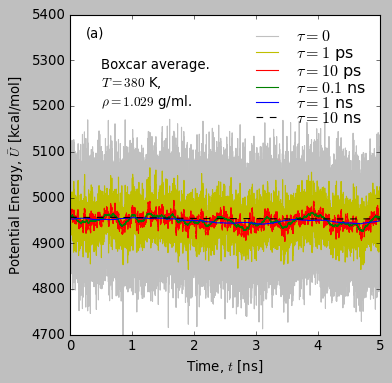

In [9]:
t = df.Time*1e9-21
plt.figure(figsize=(5, 5))
plt.plot(t, df.PotEng, '-', color='silver', label=r'$\tau=0$')
plt.plot(t, uniform_filter1d(df.PotEng, int(spns/1000)), 'y-', label=r'$\tau=1$ ps')
plt.plot(t, uniform_filter1d(df.PotEng, int(spns/100)), 'r-', label=r'$\tau=10$ ps')
plt.plot(t, uniform_filter1d(df.PotEng, int(spns/10)), 'g-', label=r'$\tau=0.1$ ns')
plt.plot(t, uniform_filter1d(df.PotEng, int(spns)), 'b-', label=r'$\tau=1$ ns')
plt.plot(t, uniform_filter1d(df.PotEng, int(spns)*10), 'k--', label=r'$\tau=10$ ns')
plt.legend(frameon=False, labelspacing=0.01)
plt.xlabel(r'Time, $t$ [ns]')
plt.ylabel(r'Potential Energy, $\bar U$ [kcal/mol]')
plt.text(0.5, 5200, 'Boxcar average.\n' + r'$T = 380$ K,' + '\n' + r'$\rho=1.029$ g/ml.')
# Put (a) in the upper left corner
plt.text(0.05, 0.93, '(a)', transform=plt.gca().transAxes)
plt.xlim(0, 5)
plt.ylim(4700, 5400)
plt.savefig('boxcar.pdf', bbox_inches='tight')
plt.savefig('boxcar.png', bbox_inches='tight')

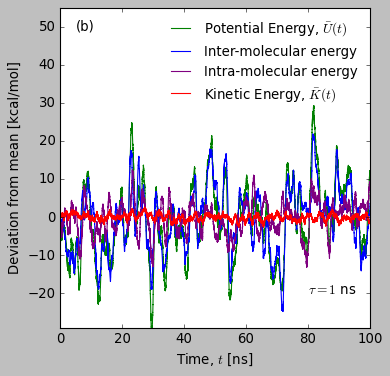

In [10]:
t = df.Time*1e9-21
plt.figure(figsize=(5, 5))
plt.plot(t, uniform_filter1d(df.PotEng, int(spns))-df.PotEng.mean(), 'g-', label=r'Potential Energy, $\bar U(t)$')
plt.plot(t, uniform_filter1d(df.E_inter, int(spns))-df.E_inter.mean(), 'b-', label=r'Inter-molecular energy')
plt.plot(t, uniform_filter1d(df.E_mol, int(spns))-df.E_mol.mean(), '-', color='purple', label=r'Intra-molecular energy')
plt.plot(t, uniform_filter1d(df.KinEng, int(spns))-df.KinEng.mean(), 'r-', label=r'Kinetic Energy, $\bar K(t)$')
plt.xlabel(r'Time, $t$ [ns]')
plt.ylabel(r'Deviation from mean [kcal/mol]')
#plt.text(0.5, 5250, 'Boxcar average.\n' + r'$T = 380$ K,' + '\n' + r'$\rho=1.030$ g/ml.')
plt.text(80, -20, r'$\tau=1$ ns')
plt.text(0.05, 0.93, '(b)', transform=plt.gca().transAxes)
plt.xlim(0, 100)
plt.ylim(-29, 55)
plt.legend(frameon=False, loc='upper right', fontsize=12)
plt.savefig('boxcar_energy.pdf', bbox_inches='tight')
plt.savefig('boxcar_energy.png', bbox_inches='tight')

59.980637982893676
28.145155888219342
59.089076131093776
58.511670449264315


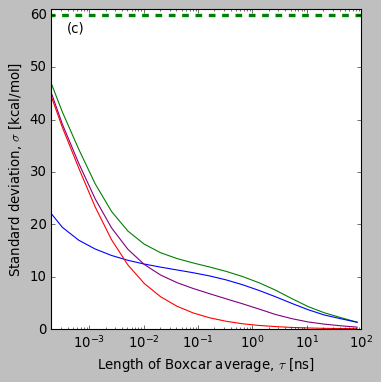

In [11]:
plt.figure(figsize=(5, 5))

def plot_curve(data, **kwarks):
    sigmas = []
    taus = []
    size = 1
    while size < len(data)/10:
        size=size*2
        taus.append(size/spns)
        sigmas.append(uniform_filter1d(data, size).std())
    plt.plot(taus, sigmas, '-', **kwarks)
    zero_level = data.std()
    #plt.plot([1e-4, 1e0], [zero_level]*2, '--', **kwarks)
    print(zero_level)

plot_curve(df.PotEng, color='g', label=r'Potential Energy, $\bar U(t)$')
plot_curve(df.E_inter, color='b', label=r'Inter-molecular energy')
plot_curve(df.E_mol, color='purple', label=r'Intra-molecular energy')
plot_curve(df.KinEng, color='r', label=r'Kinetic Energy, $\bar K(t)$')

zero_level = df.PotEng.std()
plt.plot([1e-4, 1e2], [zero_level]*2, 'g--', lw=3)
plt.ylabel(r'Standard deviation, $\sigma$ [kcal/mol]')
plt.xlabel(r'Length of Boxcar average, $\tau$ [ns]')
plt.xscale('log')
plt.ylim(0, 61)
plt.xlim(2e-4,1e2)
#plt.legend(frameon=False, loc='upper right', fontsize=12)
plt.text(0.05, 0.93, '(c)', transform=plt.gca().transAxes)
#plt.text(5e-1, 25, 'Ortho-terphenyl:\n' + r'$T = 380$ K,' + '\n' + r'$\rho=1.029$ g/ml.')
plt.savefig('boxcar_standard_deviation.pdf', bbox_inches='tight')
plt.savefig('boxcar_standard_deviation.png', bbox_inches='tight')

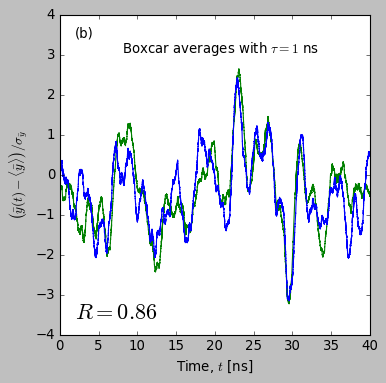

In [50]:
t = df.Time*1e9-21
plt.figure(figsize=(5, 5))
y = uniform_filter1d(df.PotEng, int(spns))-df.PotEng.mean()
plt.plot(t, y/np.std(y), 'g-', label=r'Potential Energy, $\bar y(t) = \bar U(t; \tau)$')
y = uniform_filter1d(df.c_virial, int(spns))-df.c_virial.mean()
plt.plot(t, y/np.std(y), 'b-', label=r'Virial, $\bar y(t) = \bar W(t; \tau)$')
plt.xlabel(r'Time, $t$ [ns]')
plt.ylabel(r'$\left(\bar y(t)-\langle \bar y\rangle\right)/\sigma_{\bar y}$')
#plt.text(0.5, 5250, 'Boxcar average.\n' + r'$T = 380$ K,' + '\n' + r'$\rho=1.030$ g/ml.')
plt.text(0.2, 0.88, r'Boxcar averages with $\tau=1$ ns', transform=plt.gca().transAxes, fontsize=12)
plt.text(0.05, 0.93, '(b)', transform=plt.gca().transAxes)
plt.text(0.05, 0.05, f'$R = 0.86$', transform=plt.gca().transAxes, ha='left', fontsize=20)
plt.xlim(0, 40)
#plt.ylim(-29, 55)
#plt.legend(frameon=False, loc='upper right', fontsize=12)
plt.savefig('boxcar_virial_energy.pdf', bbox_inches='tight')
plt.savefig('boxcar_virial_energy.png', bbox_inches='tight')

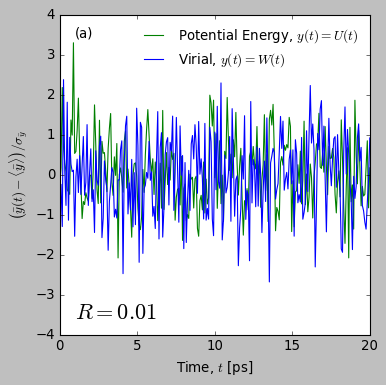

In [45]:
t = df.Time*1e9-21
plt.figure(figsize=(5, 5))
y = df.PotEng-df.PotEng.mean()
plt.plot(t*1e3, y/np.std(y), 'g-', label=r'Potential Energy, $y(t) = U(t)$')
y = df.c_virial-df.c_virial.mean()
plt.plot(t*1e3, y/np.std(y), 'b-', label=r'Virial, $y(t) = W(t)$')
plt.xlabel(r'Time, $t$ [ps]')
plt.ylabel(r'$\left(\bar y(t)-\langle \bar y\rangle\right)/\sigma_{\bar y}$')
#plt.text(0.5, 5250, 'Boxcar average.\n' + r'$T = 380$ K,' + '\n' + r'$\rho=1.030$ g/ml.')
#plt.text(0.1, 0.1, r'$\tau=0$ ns', transform=plt.gca().transAxes)
corrcoef = np.corrcoef(df.PotEng, df.c_virial)[0,1]
plt.text(0.05, 0.05, f'$R = {corrcoef:.2f}$', transform=plt.gca().transAxes, ha='left', fontsize=20)
plt.text(0.05, 0.93, '(a)', transform=plt.gca().transAxes)
plt.xlim(0, 20)
plt.ylim(-4, 4)
plt.legend(frameon=False, loc='upper right', fontsize=12)
plt.savefig('boxcar_virial_energy_fast.pdf', bbox_inches='tight')
plt.savefig('boxcar_virial_energy_fast.png', bbox_inches='tight')



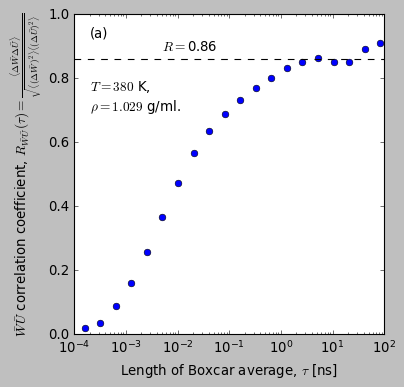

In [12]:
plt.figure(figsize=(5, 5))
Rs = []
taus = []
size = 1
while size < len(df.PotEng)/10:
    size=size*2
    taus.append(size/spns)
    A = uniform_filter1d(df.PotEng, size)
    B = uniform_filter1d(df.c_virial, size)
    R = np.corrcoef(A, B)
    Rs.append(R[0, 1])
plt.plot(taus, Rs, 'bo')
R_long_time = 0.86
plt.plot([1e-4, 100], [R_long_time]*2, 'k--')
plt.text(5e-3, 0.9, r'$R=$' f'{R_long_time}', va='center')
plt.xscale('log')
plt.xlabel(r'Length of Boxcar average, $\tau$ [ns]')
plt.ylabel(r'$\bar W$$\bar U$ correlation coefficient, $R_{\bar W\bar U}(\tau)=\frac{\langle \Delta \bar W\Delta \bar U\rangle}{\sqrt{\langle (\Delta \bar W)^2\rangle\langle (\Delta \bar U)^2\rangle}}$')
plt.text(0.05, 0.93, '(a)', transform=plt.gca().transAxes)
plt.text(2e-4, 0.7,'$T = 380$ K,' + '\n' + r'$\rho=1.029$ g/ml.')
plt.ylim(0, 1)
plt.xlim(1e-4, 1e2)
plt.savefig('boxcar_correlation_coefficient.pdf', bbox_inches='tight')
plt.savefig('boxcar_correlation_coefficient.png', bbox_inches='tight')

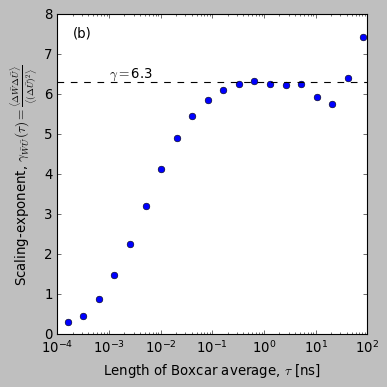

In [13]:
plt.figure(figsize=(5, 5))
gammas = []
taus = []
size = 1
while size < len(df.PotEng)/10:
    size=size*2
    taus.append(size/spns)
    A = uniform_filter1d(df.PotEng, size)
    B = uniform_filter1d(df.c_virial, size)
    cov = np.cov(A, B)
    gammas.append(cov[0, 1]/A.var())
plt.plot(taus, gammas, 'bo')
gamma_long_time = 6.3
plt.plot([1e-4, 100], [gamma_long_time]*2, 'k--')
plt.text(1e-3, gamma_long_time+0.2, r'$\gamma=$' f'{gamma_long_time}', va='center')
plt.text(0.05, 0.93, '(b)', transform=plt.gca().transAxes)
plt.xscale('log')
plt.xlabel(r'Length of Boxcar average, $\tau$ [ns]')
plt.ylabel(r'Scaling-exponent, $\gamma_{\bar W\bar U}(\tau)=\frac{\langle\Delta\bar W\Delta\bar U\rangle}{\langle(\Delta\bar U)^2\rangle}$')
#plt.text(2e-1, 0.7, r'ortho-terphenyl,' + '\n' + '$T = 380$ K,' + '\n' + r'$\rho=1.030$ g/ml.')
#plt.ylim(0, 1)
plt.xlim(1e-4, 1e2)
plt.savefig('boxcar_scaling_exponent.pdf', bbox_inches='tight')
plt.savefig('boxcar_scaling_exponent.png', bbox_inches='tight')

In [14]:
C_UU = analyse.time_correlation(df.PotEng)
C_WW = analyse.time_correlation(df.c_virial)
C_WU = analyse.time_correlation(df.c_virial, df.PotEng)

In [15]:
points_per_decade = 6
t_log = analyse.run_avg_log(df.Time, points_per_decade)
C_UU_log = analyse.run_avg_log(C_UU, points_per_decade)
C_WW_log = analyse.run_avg_log(C_WW, points_per_decade)
C_WU_log = analyse.run_avg_log(C_WU, points_per_decade)

[169.13726871   0.62187108   0.49308171]


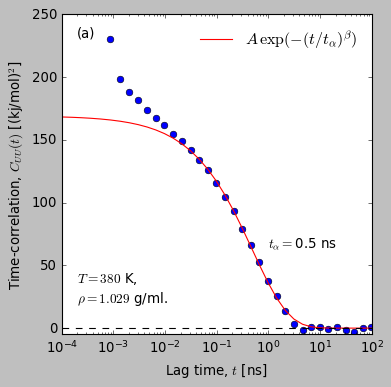

In [16]:
# Plot energy-energy correlation function

# Fit stretch exponential to the long-time tail of C_UU
max_y_value = 150
def stretched_exponential(t, A, beta, t_alpha):
    return A*np.exp(-(t/t_alpha)**beta)
# Find long tail data
long_tail = C_UU_log < max_y_value
pguess = [150, 0.8, 0.8]
popt, pcov = scipy.optimize.curve_fit(stretched_exponential, t_log[long_tail]*1e9, C_UU_log[long_tail], p0=pguess)
print(popt)
A, beta, t_alpha = popt


# Plot energy-energy correlation function
plt.figure(figsize=(5, 5))
plt.plot(t_log*1e9, C_UU_log, 'bo')
#plt.plot(t_log*1e9, stretched_exponential(t_log*1e9, *pguess), 'r--', label='guess')
plt.plot(t_log*1e9, stretched_exponential(t_log*1e9, *popt), 'r-', label=r'$A\,\exp(-(t/t_\alpha)^\beta)$')
plt.xscale('log')
plt.text(t_alpha*2, A/2.5, r'$t_\alpha = $' f'{t_alpha:.1g} ns', va='center')
plt.plot([1e-4, 100], [0]*2, 'k--')
plt.ylim(-5, 250)
plt.xlim(1e-4, 100)
plt.ylabel(r'Time-correlation, $C_{UU}(t)$ [(kj/mol)$^2$]')
plt.xlabel(r'Lag time, $t$ [ns]')
plt.text(0.05, 0.1,'$T = 380$ K,' + '\n' + r'$\rho=1.029$ g/ml.', transform=plt.gca().transAxes)
plt.text(0.05, 0.93, '(a)', transform=plt.gca().transAxes)
plt.legend(frameon=False, loc='upper right', numpoints=1)
plt.savefig('CUU_time_correlation.pdf', bbox_inches='tight')
plt.savefig('CUU_time_correlation.png', bbox_inches='tight')
plt.show()

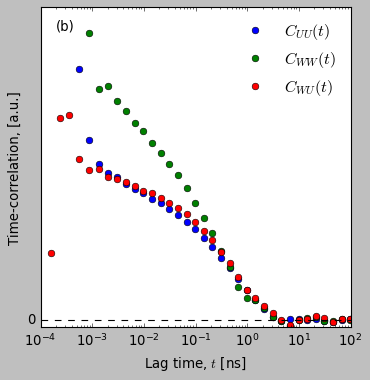

In [17]:
plt.figure(figsize=(5, 5))
plt.plot(t_log*1e9, C_UU_log/100, 'bo', label=r'$C_{UU}(t)$')
plt.plot(t_log*1e9, C_WW_log/5000, 'go', label=r'$C_{WW}(t)$')
plt.plot(t_log*1e9, C_WU_log/600, 'ro', label=r'$C_{WU}(t)$')
plt.plot([1e-4, 100], [0]*2, 'k--')
plt.xscale('log')
plt.ylim(-0.1, 4)
plt.xlim(1e-4, 100)
plt.yticks([0])
plt.text(0.05, 0.93, '(b)', transform=plt.gca().transAxes)

plt.ylabel(r'Time-correlation, [a.u.]')
plt.xlabel(r'Lag time, $t$ [ns]')
plt.legend(frameon=False, loc='upper right', numpoints=1)
plt.savefig('all_time_correlation.pdf', bbox_inches='tight')
plt.savefig('all_time_correlation.png', bbox_inches='tight')
plt.show()

/tmp/ipykernel_9783/929768490.py:3: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(t_log*1e9, C_WU_log/np.sqrt(C_UU_log*C_WW_log), 'bo', label=r'$R_{WU}(\tau)$')


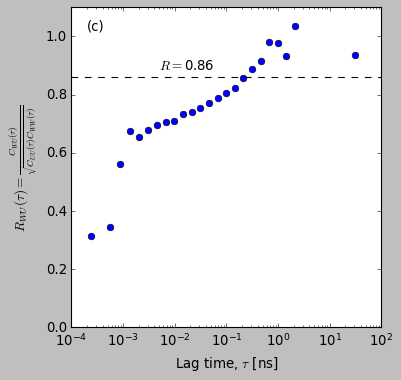

In [18]:
# Time-dependent correlation coefficient
plt.figure(figsize=(5, 5))
plt.plot(t_log*1e9, C_WU_log/np.sqrt(C_UU_log*C_WW_log), 'bo', label=r'$R_{WU}(\tau)$')
plt.plot([1e-4, 100], [R_long_time]*2, 'k--')
plt.text(5e-3, 0.9, r'$R=$' f'{R_long_time}', va='center')
plt.text(0.05, 0.93, '(c)', transform=plt.gca().transAxes)

plt.xscale('log')
plt.ylim(0, 1.1)
plt.xlim(1e-4, 100)
plt.ylabel(r'$R_{WU}(\tau)=\frac{C_{WU}(\tau)}{\sqrt{C_{UU}(\tau)C_{WW}(\tau)}}$')
plt.xlabel(r'Lag time, $\tau$ [ns]')
plt.show()

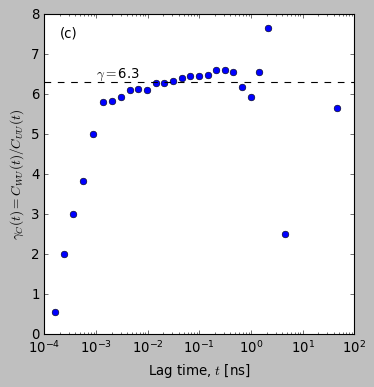

In [19]:
# Time-dependent scaling exponent
plt.figure(figsize=(5, 5))
plt.plot(t_log*1e9, C_WU_log/C_UU_log, 'bo', label=r'$\gamma_{WU}(\tau)$')
plt.plot([1e-4, 100], [gamma_long_time]*2, 'k--')
plt.text(1e-3, gamma_long_time+0.2, r'$\gamma = $' f'{gamma_long_time}', va='center')
plt.xscale('log')
plt.text(0.05, 0.93, '(c)', transform=plt.gca().transAxes)
plt.ylim(0, 8)
plt.xlim(1e-4, 100)
plt.ylabel(r'$\gamma_{C}(t)=C_{WU}(t)/C_{UU}(t)$')
plt.xlabel(r'Lag time, $t$ [ns]')
plt.savefig('gamma_WU_time_correlation.pdf', bbox_inches='tight')
plt.savefig('gamma_WU_time_correlation.png', bbox_inches='tight')
plt.show()

In [20]:
dt = float(df.reset_index().Time[1] - df.reset_index().Time[0])*1e9  # Time step in ns
omega, mu_EE = analyse.frequency_dependent_response(df.PotEng, df.PotEng, dt=dt)
_, mu_WW = analyse.frequency_dependent_response(df.c_virial, df.c_virial, dt=dt)
_, mu_EW = analyse.frequency_dependent_response(df.PotEng, df.c_virial, dt=dt)

In [21]:
points_per_decade = 6
omega_log = analyse.run_avg_log(omega, points_per_decade)
mu_EE_log = analyse.run_avg_log(mu_EE, points_per_decade)
mu_WW_log = analyse.run_avg_log(mu_WW, points_per_decade)
mu_EW_log = analyse.run_avg_log(mu_EW, points_per_decade)

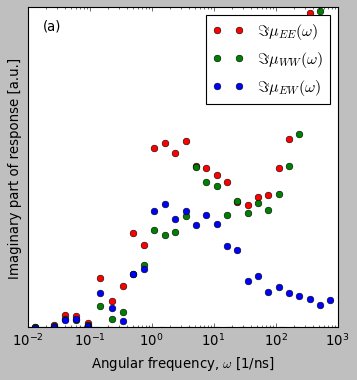

In [22]:
# Plot frequency-dependent response
plt.figure(figsize=(5, 5))
plt.plot(omega_log, np.imag(mu_EE_log)/100, 'ro', label=r'$\Im\mu_{EE}(\omega)$')
plt.plot(omega_log, np.imag(mu_WW_log)/10000, 'go', label=r'$\Im\mu_{WW}(\omega)$')
plt.plot(omega_log, np.imag(mu_EW_log)/1000, 'bo', label=r'$\Im\mu_{EW}(\omega)$')
plt.plot([0, 1e13], [0, 0], 'k--')
plt.xlim(1e-2,1e3)
plt.ylim(0, 1)
plt.yticks([])
plt.text(0.05, 0.93, '(a)', transform=plt.gca().transAxes)
plt.xscale('log')
plt.xlabel(r'Angular frequency, $\omega$ [1/ns]')
plt.ylabel(r'Imaginary part of response [a.u.]')
plt.legend()
plt.savefig('all_response.pdf', bbox_inches='tight')
plt.savefig('all_response.png', bbox_inches='tight')
plt.show()

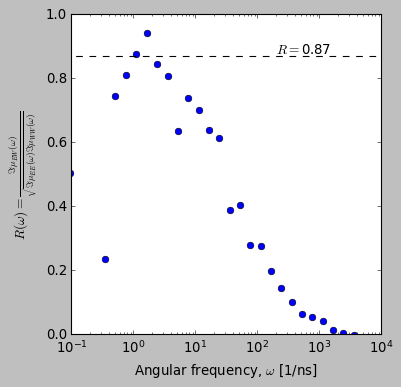

In [23]:
# Plot frequency-dependent correlation coefficient
plt.figure(figsize=(5, 5))
plt.plot(omega_log, np.imag(mu_EW_log)/np.sqrt(np.imag(mu_EE_log)*np.imag(mu_WW_log)), 'bo', label=r'$R(\omega)$')
R_long_time = 0.87
plt.plot([1e-2, 1e4], [R_long_time]*2, 'k--')
plt.text(2e2, R_long_time+0.02, r'$R=$' f'{R_long_time}', va='center')
plt.xlim(1e-1,1e4)
plt.ylim(0, 1)
plt.xscale('log')
plt.xlabel(r'Angular frequency, $\omega$ [1/ns]')
plt.ylabel(r'$R(\omega)=\frac{\Im\mu_{EW}(\omega)}{\sqrt{\Im\mu_{EE}(\omega)\Im\mu_{WW}(\omega)}}$')

plt.show()

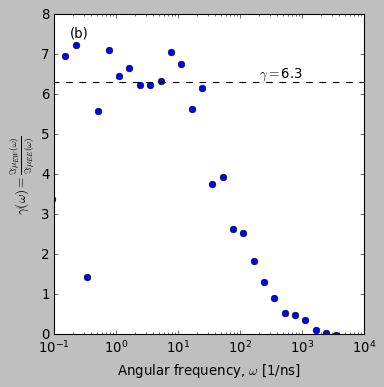

In [24]:
# Plot the frequency dependent scaling exponent
plt.figure(figsize=(5, 5))
plt.plot(omega_log, np.imag(mu_EW_log)/np.imag(mu_EE_log), 'bo', label=r'$\gamma(\omega)$')
plt.plot([1e-2, 1e4], [gamma_long_time]*2, 'k--')
plt.text(2e2, gamma_long_time+0.2, r'$\gamma=$' f'{gamma_long_time}', va='center')
plt.text(0.05, 0.93, '(b)', transform=plt.gca().transAxes)
plt.xlim(1e-1,1e4)
plt.ylim(0, 8)
plt.xscale('log')
plt.xlabel(r'Angular frequency, $\omega$ [1/ns]')
plt.ylabel(r'$\gamma(\omega)=\frac{\Im\mu_{EW}(\omega)}{\Im\mu_{EE}(\omega)}$')
plt.savefig('gamma_WU_response.pdf', bbox_inches='tight')
plt.savefig('gamma_WU_response.png', bbox_inches='tight')
plt.show()